In [338]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
import functions_fatiando as ft
from timeit import default_timer as time
from matplotlib import pyplot as plt
%matplotlib inline

## Create the model

In [339]:
# Polygonal Prism model
verts1 = [[-3500, -3000], [-2000, -3000], [-2000, 3000], [-3500, 3000]]
#verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'density':550})]

R1 = 1000 #Radius 1
R2 = 750 #Radius 2
xc1, yc1, zc1 = 3000., -2000., 2000. #Center of sphere 1
xc2, yc2, zc2 = 1000., 2500., 1800. #Center of sphere 2
model_sphere = [ft.mesher_Sphere(xc1, yc1, zc1 ,R1, props={'density':600}),
                ft.mesher_Sphere(xc2, yc2, zc2, R2, props={'density': -500})]

## Grid and Forward model

In [370]:
# Create a regular grid at 0m height
shape = (50, 50)
N = shape[0]*shape[1]
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = ft.gridder_regular(area, shape, z=-100.)
xi_plot = xi/1000
yi_plot = yi/1000
#print (area[1]-area[0])/(shape[0]-1.)

In [371]:
# Vertical component of the gravitational atraction observed
data = []
delta_g = []
dobs_prism = ft.polyprism_gz(xi, yi, zi, model_prism)
dobs_sphere = ft.sphere_gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

## True data plot noise free

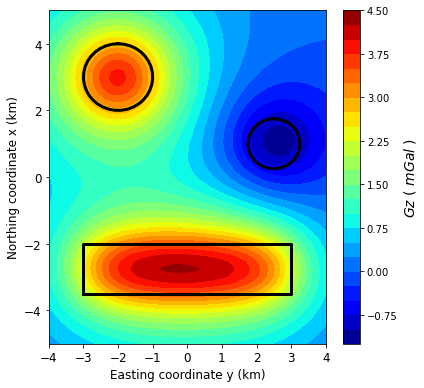

In [372]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

#x_p2 = [-3, -2.5, 3.5, 3, -3.]
#y_p2 = [4, 4.5, 0, -0.5, 4]

# plot of the vertical component of the gravitational atraction at z=0 
fig=plt.figure(figsize=(6,5.5))
fig.patch.set_facecolor('xkcd:white')
plt.plot()
plt.tricontourf(yi_plot,xi_plot,data[0],22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (km)', fontsize=12)
#mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout();
#plt.savefig('figures/synthetic_data.png', dpi=300)

## Equivalent Layer Depth

In [373]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Classical Equivalent layer

In [344]:
#delta_p_classical_0 = []
#A = fc.sensibility_matrix(xi,yi,zi,zj,N)
#I = np.identity(N)
#ATA = A.T.dot(A)
#mu = (np.trace(ATA)/N)*10**(-10)
#AI = np.linalg.inv(ATA+mu*I)
#p_0 = (AI.dot(A.T)).dot(data[0])
#norm_p_0 = np.linalg.norm(p_0)
#for i in range(len(data)-1):
#    p = (AI.dot(A.T)).dot(data[i+1])
#    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
#    delta_p_classical_0.append(norm_pl)

In [345]:
delta_p_classical = []
A = fc.sensibility_matrix(xi,yi,zi,zj,N)
I = np.identity(N)
ATA = A.T.dot(A)
mu = (np.trace(ATA)/N)*10**(-2)
AI = np.linalg.inv(ATA+mu*I)
p_0 = (AI.dot(A.T)).dot(data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p = (AI.dot(A.T)).dot(data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical.append(norm_pl)

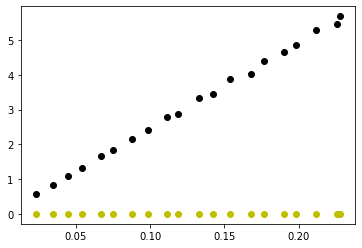

In [346]:
plt.plot(delta_g,delta_p_classical_0, 'yo')
plt.plot(delta_g,delta_p_classical, 'ko')

## Fast Eq. Layer BCCB

In [374]:
# Predicted data
delta_p_BCCB = []
itmax = 40
rho_c_0, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[0],itmax)
norm_rho_c_0 = np.linalg.norm(rho_c_0)
for i in range(len(data)-1):
    rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[i+1],itmax)
    norm_rho_c = np.linalg.norm(rho_c-rho_c_0)/norm_rho_c_0
    delta_p_BCCB.append(norm_rho_c)

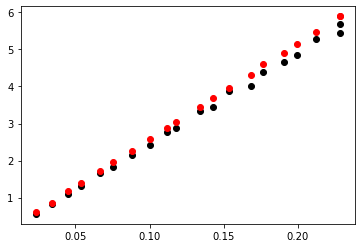

In [375]:
#plt.plot(delta_g,delta_p_classical_0, 'yo')
plt.plot(delta_g,delta_p_classical, 'ko')
plt.plot(delta_g,delta_p_BCCB, 'ro')

## Deconvolution

In [376]:
delta_p_dec = []
BTTB = fc.bttb(xi,yi,zi,zj)
cev = fc.bccb(shape,N,BTTB)
w = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
w = w.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
rho_c_0_dec = np.ravel(np.real(rho_c_0_dec[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for j in range(len(data)-1):
    w = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w = w.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
    rho_c_dec = np.ravel(np.real(rho_c_dec[:shape[1],:shape[0]]).T)
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution with Wiener stabilization

In [377]:
# Regularization factor of Wiener deconvolution
a, b, c = -15, -20, -25
mu0 = 10**(a)
mu1 = 10**(b)
mu2 = 10**(c)

delta_p_dec_wiener0 = []
delta_p_dec_wiener1 = []
delta_p_dec_wiener2 = []
BTTB_wiener = fc.bttb(xi,yi,zi,zj)
cev_wiener = fc.bccb(shape,N,BTTB_wiener)

w_wiener = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w_wiener[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
    
w_wiener = w_wiener.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec_wiener = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu0))
rho_c_0_dec_wiener = np.ravel(np.real(rho_c_0_dec_wiener[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)

rho_c_1_dec_wiener = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu1))
rho_c_1_dec_wiener = np.ravel(np.real(rho_c_1_dec_wiener[:shape[1],:shape[0]]).T)
norm_rho_c_1_dec_wiener = np.linalg.norm(rho_c_1_dec_wiener)

rho_c_2_dec_wiener = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu2))
rho_c_2_dec_wiener = np.ravel(np.real(rho_c_2_dec_wiener[:shape[1],:shape[0]]).T)
norm_rho_c_2_dec_wiener = np.linalg.norm(rho_c_2_dec_wiener)

for j in range(len(data)-1):
    w_wiener = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w_wiener[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w_wiener = w_wiener.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec_wiener0 = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu0))
    rho_c_dec_wiener0 = np.ravel(np.real(rho_c_dec_wiener0[:shape[1],:shape[0]]).T)
    norm_rho_c_dec_wiener0 = np.linalg.norm(rho_c_dec_wiener0-rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    delta_p_dec_wiener0.append(norm_rho_c_dec_wiener0)
    
    rho_c_dec_wiener1 = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu1))
    rho_c_dec_wiener1 = np.ravel(np.real(rho_c_dec_wiener1[:shape[1],:shape[0]]).T)
    norm_rho_c_dec_wiener1 = np.linalg.norm(rho_c_dec_wiener1-rho_c_1_dec_wiener)/norm_rho_c_1_dec_wiener
    delta_p_dec_wiener1.append(norm_rho_c_dec_wiener1)
    
    rho_c_dec_wiener2 = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu2))
    rho_c_dec_wiener2 = np.ravel(np.real(rho_c_dec_wiener2[:shape[1],:shape[0]]).T)
    norm_rho_c_dec_wiener2 = np.linalg.norm(rho_c_dec_wiener2-rho_c_2_dec_wiener)/norm_rho_c_2_dec_wiener
    delta_p_dec_wiener2.append(norm_rho_c_dec_wiener2)

In [378]:
np.mean(cev_wiener*np.conj(cev_wiener))

(1.312420554465809e-20+0j)

## Straight line fits

In [379]:
#coe0 = np.polyfit(delta_g, delta_p_classical_0, 1)
#poly1d_fn0 = np.poly1d(coe0)

coe = np.polyfit(delta_g, delta_p_classical, 1)
poly1d_fn = np.poly1d(coe)

coe2 = np.polyfit(delta_g, delta_p_BCCB, 1)
poly1d_fn2 = np.poly1d(coe2)

coe3 = np.polyfit(delta_g, delta_p_dec, 1)
poly1d_fn3 = np.poly1d(coe3)

coe4 = np.polyfit(delta_g, delta_p_dec_wiener0, 1)
poly1d_fn4 = np.poly1d(coe4)

coe5 = np.polyfit(delta_g, delta_p_dec_wiener1, 1)
poly1d_fn5 = np.poly1d(coe5)

coe6 = np.polyfit(delta_g, delta_p_dec_wiener2, 1)
poly1d_fn6 = np.poly1d(coe6)

## Figure plots

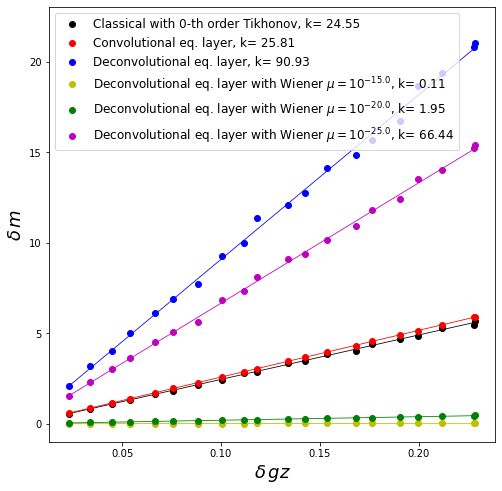

In [380]:
fig=plt.figure(figsize=(8,8))
fig.patch.set_facecolor('xkcd:white')
#plt.plot(delta_g,delta_p_classical_0, 'yo', label='Classical without Tikhonov')
plt.plot(delta_g,delta_p_classical, 'ko', label='Classical with 0-th order Tikhonov, k= %.2f' % (coe[0]))
plt.plot(delta_g,poly1d_fn(delta_g), 'k-', linewidth=0.8)
plt.plot(delta_g,delta_p_BCCB, 'ro', label='Convolutional eq. layer, k= %.2f' % (coe2[0]))
plt.plot(delta_g,poly1d_fn2(delta_g), 'r-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec, 'bo', label='Deconvolutional eq. layer, k= %.2f' % (coe3[0]))
plt.plot(delta_g,poly1d_fn3(delta_g), 'b-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener0, 'yo', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (a, coe4[0]))
plt.plot(delta_g,poly1d_fn4(delta_g), 'y-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener1, 'go', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (b, coe5[0]))
plt.plot(delta_g,poly1d_fn5(delta_g), 'g-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener2, 'mo', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (c, coe6[0]))
plt.plot(delta_g,poly1d_fn6(delta_g), 'm-', linewidth=0.8)
plt.ylim(np.min(delta_p_dec_wiener0)-1,np.max(delta_p_dec)+2)
plt.xlabel('$\delta \, gz$', fontsize=18)
plt.ylabel('$\delta \, m$', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
#plt.savefig('../../manuscript/Fig/stability_grav_2.png', dpi=300)

## Fit comparison

In [381]:
A = fc.sensibility_matrix(xi,yi,zi,zj,N)

gz_classic = np.dot(A,p)
gz_bccb = np.dot(A,rho_c)
gz_dec = np.dot(A,rho_c_dec)
gz_dec_wiener0 = np.dot(A,rho_c_dec_wiener0)
gz_dec_wiener1 = np.dot(A,rho_c_dec_wiener1)
gz_dec_wiener2 = np.dot(A,rho_c_dec_wiener2)

ValueError: shapes (2500,2500) and (3025,) not aligned: 2500 (dim 1) != 3025 (dim 0)

In [ ]:
scale_max = np.max(gz_classic)
scale_min = np.min(gz_classic)

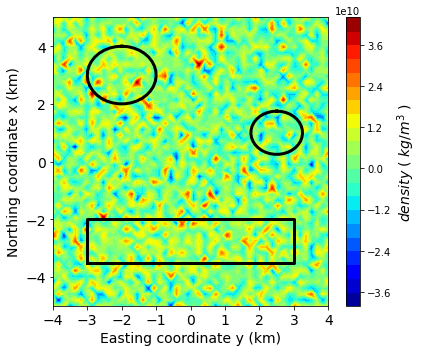

In [382]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,rho_c,22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg/m^{3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

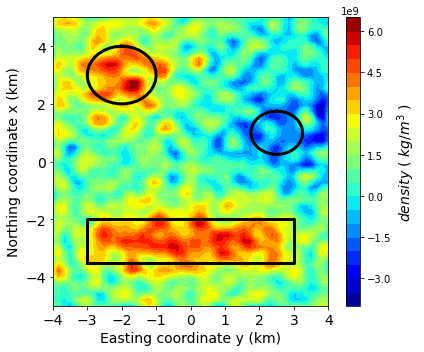

In [383]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,rho_c_dec_wiener1, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg/m^{3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

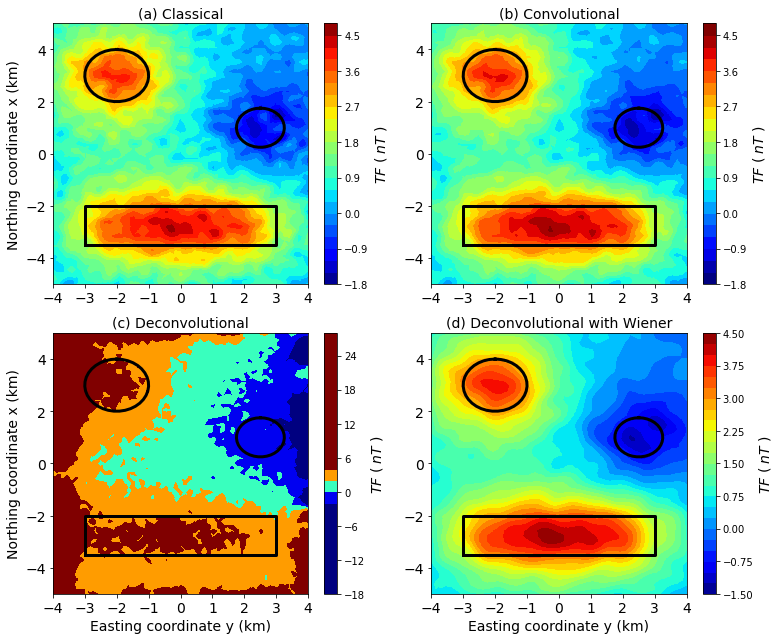

In [358]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a) Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_classic,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b) Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_bccb,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c) Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d) Deconvolutional with Wiener', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener1,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/stability_grav_comparison.png', dpi=300)

In [359]:
print (np.mean(np.abs(data[-1]-gz_classic)), ('(Classical method)'))
print (np.mean(np.abs(data[-1]-gz_bccb)), ('(CG BTTB method)'))
print (np.mean(np.abs(data[-1]-gz_dec)), ('(Deconvolutional method)'))
print (np.mean(np.abs(data[-1]-gz_dec_wiener0)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(data[-1]-gz_dec_wiener1)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(data[-1]-gz_dec_wiener2)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(data[-1]-gz_classic)), ('(Classical method)'))
print (np.std(np.abs(data[-1]-gz_bccb)), ('(CG BTTB method)'))
print (np.std(np.abs(data[-1]-gz_dec)), ('(Deconvolutional method)'))
print (np.std(np.abs(data[-1]-gz_dec_wiener0)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(data[-1]-gz_dec_wiener1)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(data[-1]-gz_dec_wiener2)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

0.2655718294061186 (Classical method)
0.27418227685021435 (CG BTTB method)
1.9261730466605063 (Deconvolutional method)
1.5428673977622651 (Deconvolutional w\ Wiener overshoot μ method)
0.3199976576918764 (Deconvolutional w\ Wiener optimal μ method)
1.6489033152123396 (Deconvolutional w\ Wiener suboptimal μ method)

0.1960202977148447 (Classical method)
0.20355249185867474 (CG BTTB method)
3.4173803856153016 (Deconvolutional method)
1.1130945222351596 (Deconvolutional w\ Wiener overshoot μ method)
0.2425930938552034 (Deconvolutional w\ Wiener optimal μ method)
2.8398936480849297 (Deconvolutional w\ Wiener suboptimal μ method)


## Plots for the Frontiers Paper

### Predicted classical (equivalent layer for the most noisy data)

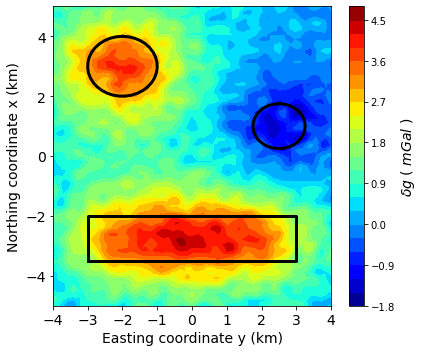

In [300]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, gz_classic, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_classic.png', dpi=300)

### Predicted CG BTTB (equivalent layer for the most noisy data)

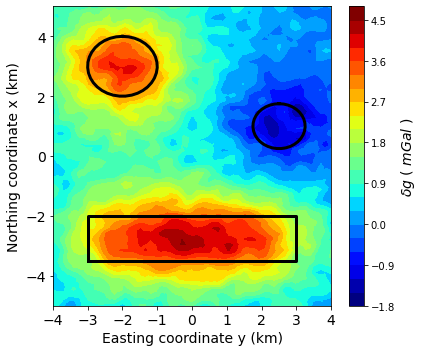

In [301]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, gz_bccb, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_bttb.png', dpi=300)

### Predicted deconvolutional (equivalent layer for the most noisy data)

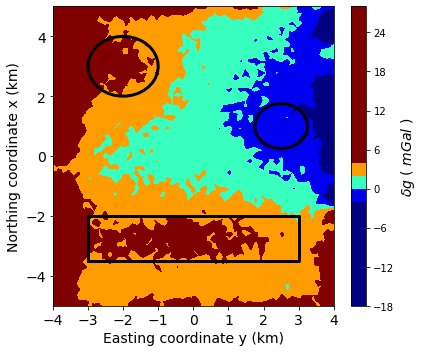

In [302]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, gz_dec, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_dec.png', dpi=300)

### Predicted deconvolutional w\ Wiener overshoot $\mu$ (equivalent layer for the most noisy data)

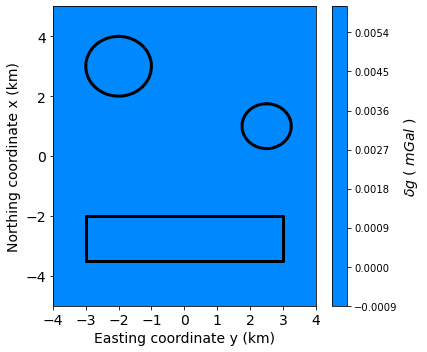

In [303]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener0, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_dec_wiener0.png', dpi=300)

### Predicted deconvolutional w\ Wiener optimal $\mu$ (equivalent layer for the most noisy data)

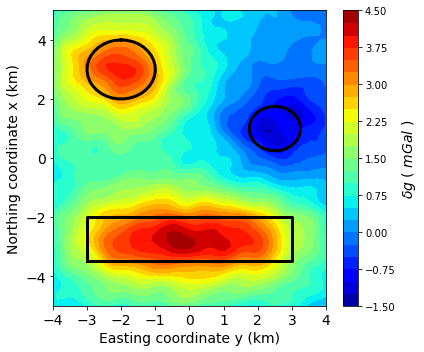

In [304]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener1, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_dec_wiener1.png', dpi=300)

### Predicted deconvolutional w\ Wiener suboptimal $\mu$ (equivalent layer for the most noisy data)

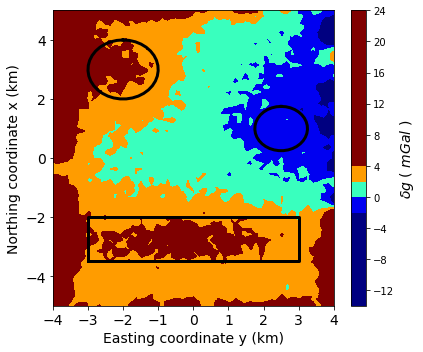

In [305]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener2, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_gz_dec_wiener2.png', dpi=300)